In [1]:
from pitas import power, flipper_tools
from orphics import maps as omaps
from pixell import enplot, enmap, curvedsky
import numpy as np
from cosmikyu import stats, mpi, datasets, config, utils, gan, transforms
import os
from itertools import product
import healpy as hp
import matplotlib.pyplot as plt
import random

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


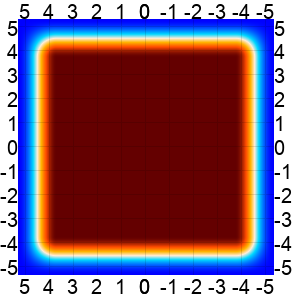

In [2]:
nside = 10
nbatch = nside*nside ## it goes like nbatch**2

shape = (128, 128)
bshape = (128*nside,128*nside)
_, bwcs = omaps.rect_geometry(width_arcmin=64.*nside, px_res_arcmin=0.5)

def get_template(shape, wcs):
    return enmap.zeros(shape, wcs)

def get_mask(taper_percent=15.):
    taper, _ = omaps.get_taper(bshape, taper_percent=taper_percent, pad_percent=0.)
    loc = taper == 0
    taper[loc] = np.min(taper[~loc])
    temp = get_template(bshape, bwcs)
    temp[...] = taper
    return temp

mask = get_mask()
enplot.pshow(mask, downgrade=5)

In [3]:
#bin_edges = flipper_tools.read_bin_edges("/home/dwhan89/workspace/pitas/resource/BIN_ACTPOL_50_4_SC_low_ell_startAt2")
#loc = np.where(bin_edges<8000)
#bin_edges = bin_edges[loc]
bin_edges = np.linspace(0,8000., 40)
PITAS = power.PITAS("082020_128x128taperv5", mask, mask, bin_edges=bin_edges, lmax=8000)


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


mcm directory: /home/dwhan89/workspace/pitas/pitas/../output/082020_128x128taperv5
trying to load /home/dwhan89/workspace/pitas/pitas/../output/082020_128x128taperv5/curved_full_DLTT_inv.dat
[get_bbl] mcm directory: /home/dwhan89/workspace/pitas/pitas/../output/082020_128x128taperv5
trying to load /home/dwhan89/workspace/pitas/pitas/../output/082020_128x128taperv5/curved_full_BBL_DLTT.dat


In [4]:
data_dir = config.default_data_dir
sehgal_dir = os.path.join(data_dir, 'sehgal')
stat_dir = os.path.join(sehgal_dir, "stats")
SDS_test = datasets.SehgalDataSet(sehgal_dir, data_type="testv3", transforms=[], dummy_label=False)
STAT_TEST = stats.STATS("sehgal_cosmoganwgpv5_test", output_dir=stat_dir, overwrite=False)

def get_data(wcs=bwcs, nside=nside, dataset=SDS_test, taper=True):
    data = SDS_test[0].copy()
    nx, ny = shape
    nshape = (data.shape[0], nx*nside, ny*nside)
    temp = enmap.zeros(nshape, wcs)
    for i in range(nside):
        for j in range(nside):
            cidx = random.randint(0, len(SDS_test)-1)
            sx = i*nx
            sy = j*ny
            temp[:,sy:sy+ny,sx:sx+nx] = SDS_test[cidx][...]
    if taper:
        temp[...] *= get_mask()
    return temp


lmax = 8000
overwrite = True
compts = ["kappa", "ksz", "tsz", "ir", "rad"]
#compts = [ "ir", "rad"]
subtasks = np.arange(300, dtype=np.int)
for sim_idx in subtasks:
    continue
    
    emap = get_data()

    alms = {}
    for i, compt_idx in enumerate(compts):
        print(i, compt_idx)
        alms[compt_idx] = curvedsky.map2alm(emap[i], lmax=lmax)
    del compt_idx

    for compt_idx1, compt_idx2 in product(compts, compts):
        compt_keys = [compt_idx1, compt_idx2]
        compt_keys.sort()
        stat_key = "dls_{}x{}".format(compt_keys[0], compt_keys[1])
        if STAT_TEST.has_data(stat_key, sim_idx):
            continue
        else:
            cl = hp.alm2cl(alms[compt_idx1], alms[compt_idx2])
            l = np.arange(len(cl), dtype=np.float)
            dl = l*(l+1.)/(2*np.pi)*cl
            lbin, dlbin = PITAS.binner.bin(l, dl)
            dlbin = np.dot(PITAS.mcm_dltt_inv, dlbin)
            STAT_TEST.add_data("lbin", 0, lbin)
            STAT_TEST.add_data(stat_key, sim_idx, dlbin)

    #del alms

_ = STAT_TEST.get_stats(save_data=False)

[STATS] output_dir is /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_sehgal_cosmoganwgpv5_test.npz
calculating stats


/home/dwhan89/workspace/cosmikyu/cosmikyu/stats.py:111: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov      = np.cov(data.transpose(), ddof=ddof)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [5]:
#norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/normalization_info_fullv3.npz"
norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/082520_normalization_info_model.npz"
experiment_id = "7349b393abf94d8a94bc3675384ff15a"
model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_cosmoganwgpv5/{}/model".format(experiment_id)
print(model_dir)
latent_dim = 64
overwrite =True
#SDUN = transforms.SehgalDataUnnormalizer(norm_info_file, zfact=4)
SDN = transforms.SehgalDataNormalizerScaledLogZ(norm_info_file)
SDUN = transforms.SehgalDataUnnormalizerScaledLogZ(norm_info_file)
#STAT = stats.STATS("sehgal_cosmoganwgpv4_generated", output_dir=stat_dir, overwrite=False)
STAT_GEN = stats.STATS(experiment_id, output_dir=stat_dir, overwrite=overwrite)
#compts = ["kappa", "ksz", "tsz", "ir", "rad"]
save_points = [25, 50]
for save_point in save_points: 
    
    DCGAN_WGP = gan.DCGAN_WGP("sehgal_dcganwgp", (5,)+shape, latent_dim, cuda=False, nconv_fcgen=64,
                                      nconv_fcdis=64, ngpu=4, nconv_layer_gen=4, nconv_layer_disc=4, kernal_size=5, stride=2,
                                                                padding=2, output_padding=1, tanh_activation=False)
    DCGAN_WGP.load_states(model_dir, "_{}".format(save_point))
    
    def get_generated(wcs=bwcs, nside=nside, gan=DCGAN_WGP, taper=True):
        shape = gan.shape
        nx, ny = shape[1], shape[2]
        nshape = (shape[0], shape[1]*nside, shape[2]*nside)
        temp = enmap.zeros(nshape, wcs)
        np.random.seed(0)
        generated = gan.generate_samples(nside*nside).data.numpy()
        #ctr = 0
        for i in range(nside):
            for j in range(nside):
                ctr = i*nside+j
                sx = i*nx
                sy = j*ny
                temp[:,sy:sy+ny,sx:sx+nx] = SDUN(generated[ctr])
        if taper:
            temp[...] *= get_mask()
        return temp
    
    subtasks = np.arange(1, dtype=np.int)
    for sim_idx in subtasks:
        emap = get_generated()
        #enplot.pshow(emap)
        alms = {}
        for i, compt_idx in enumerate(compts):
            #i += 3
            print(i, compt_idx)
            alms[compt_idx] = curvedsky.map2alm(emap[i], lmax=lmax)
        del compt_idx
        
        for compt_idx1, compt_idx2 in product(compts, compts):
            compt_keys = [compt_idx1, compt_idx2]
            compt_keys.sort()
            stat_key = "dls_{}x{}_r{}".format(compt_keys[0], compt_keys[1],save_point)
            print(stat_key)
            if STAT_GEN.has_data(stat_key, sim_idx):
                continue
            else:
                cl = hp.alm2cl(alms[compt_idx1], alms[compt_idx2])
                l = np.arange(len(cl), dtype=np.float)
                dl = l*(l+1.)/(2*np.pi)*cl
                lbin, dlbin = PITAS.binner.bin(l, dl)
                dlbin = np.dot(PITAS.mcm_dltt_inv, dlbin)
                STAT_GEN.add_data("lbin", 0, lbin)
                STAT_GEN.add_data(stat_key, sim_idx, dlbin)

        #del alms
_ = STAT_GEN.get_stats(save_data=overwrite)

Traceback (most recent call last):
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/mlruns/mlruns/meta.yaml' does not exist.


/home/dwhan89/workspace/cosmikyu/output/sehgal_cosmoganwgpv5/7349b393abf94d8a94bc3675384ff15a/model
[STATS] output_dir is /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats
[WARNING] You have a CUDA device. You probably want to run with CUDA enabled
loading saved states _25
failed to load saved states
0 kappa
1 ksz
2 tsz
3 ir
4 rad
dls_kappaxkappa_r25
dls_kappaxksz_r25
dls_kappaxtsz_r25
dls_irxkappa_r25
dls_kappaxrad_r25
dls_kappaxksz_r25
dls_kszxksz_r25
dls_kszxtsz_r25
dls_irxksz_r25
dls_kszxrad_r25
dls_kappaxtsz_r25
dls_kszxtsz_r25
dls_tszxtsz_r25
dls_irxtsz_r25
dls_radxtsz_r25
dls_irxkappa_r25
dls_irxksz_r25
dls_irxtsz_r25
dls_irxir_r25
dls_irxrad_r25
dls_kappaxrad_r25
dls_kszxrad_r25
dls_radxtsz_r25
dls_irxrad_r25
dls_radxrad_r25


Traceback (most recent call last):
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/mlruns/mlruns/meta.yaml' does not exist.


[WARNING] You have a CUDA device. You probably want to run with CUDA enabled
loading saved states _50
failed to load saved states
0 kappa
1 ksz
2 tsz
3 ir
4 rad
dls_kappaxkappa_r50
dls_kappaxksz_r50
dls_kappaxtsz_r50
dls_irxkappa_r50
dls_kappaxrad_r50
dls_kappaxksz_r50
dls_kszxksz_r50
dls_kszxtsz_r50
dls_irxksz_r50
dls_kszxrad_r50
dls_kappaxtsz_r50
dls_kszxtsz_r50
dls_tszxtsz_r50
dls_irxtsz_r50
dls_radxtsz_r50
dls_irxkappa_r50
dls_irxksz_r50
dls_irxtsz_r50
dls_irxir_r50
dls_irxrad_r50
dls_kappaxrad_r50
dls_kszxrad_r50
dls_radxtsz_r50
dls_irxrad_r50
dls_radxrad_r50
[STATS] collecting data
[STATS] saving /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_7349b393abf94d8a94bc3675384ff15a.npz from root 0
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_7349b393abf94d8a94bc3675384ff15a.npz
calculating stats


/home/dwhan89/workspace/cosmikyu/cosmikyu/stats.py:111: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov      = np.cov(data.transpose(), ddof=ddof)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 432x288 with 0 Axes>

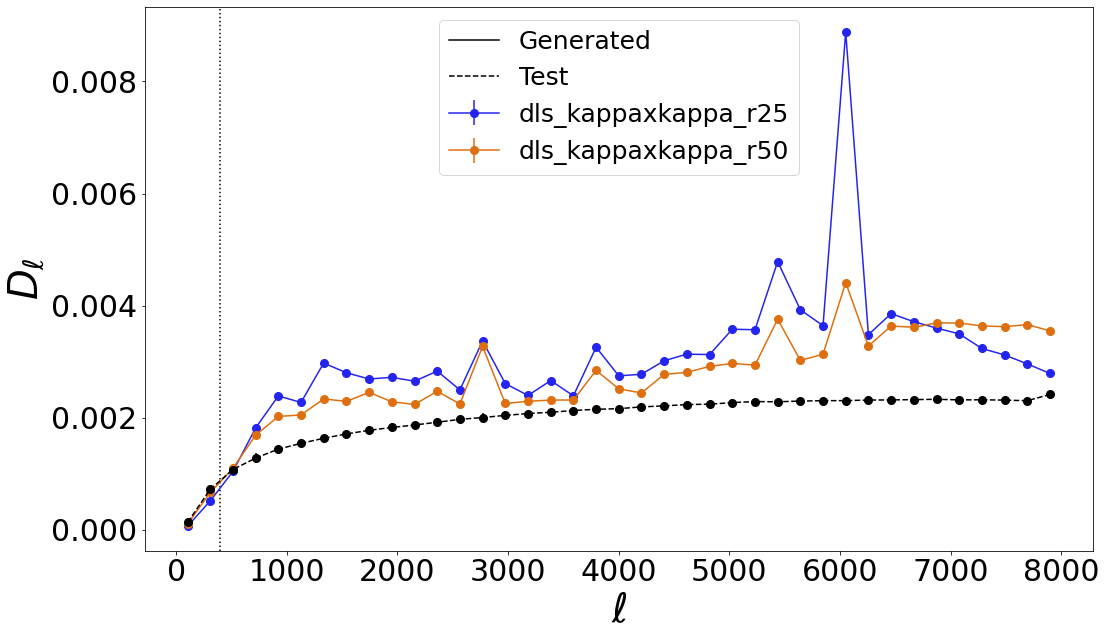

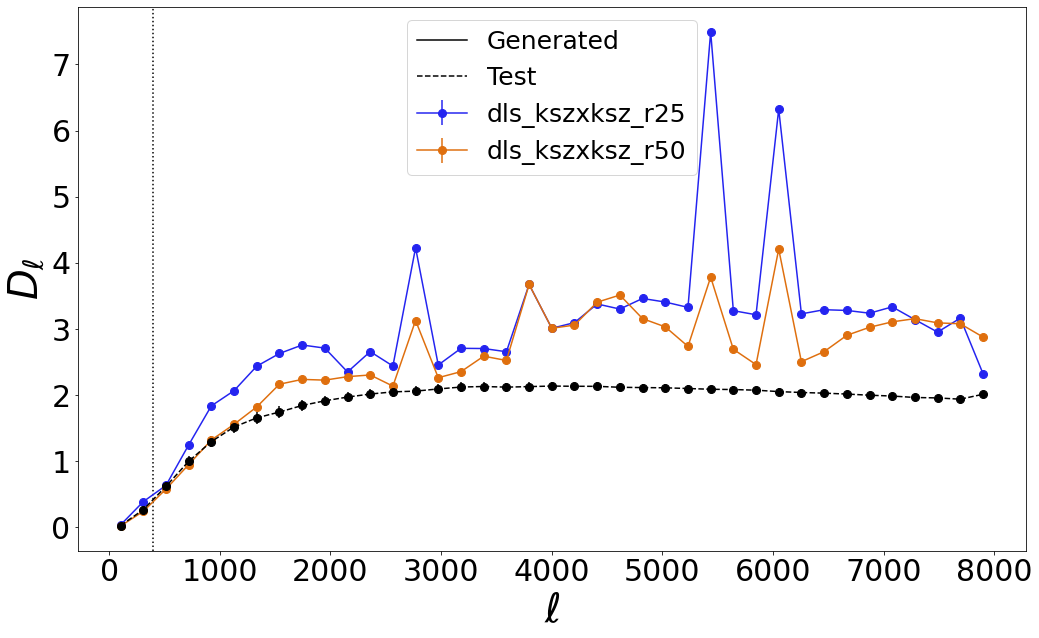

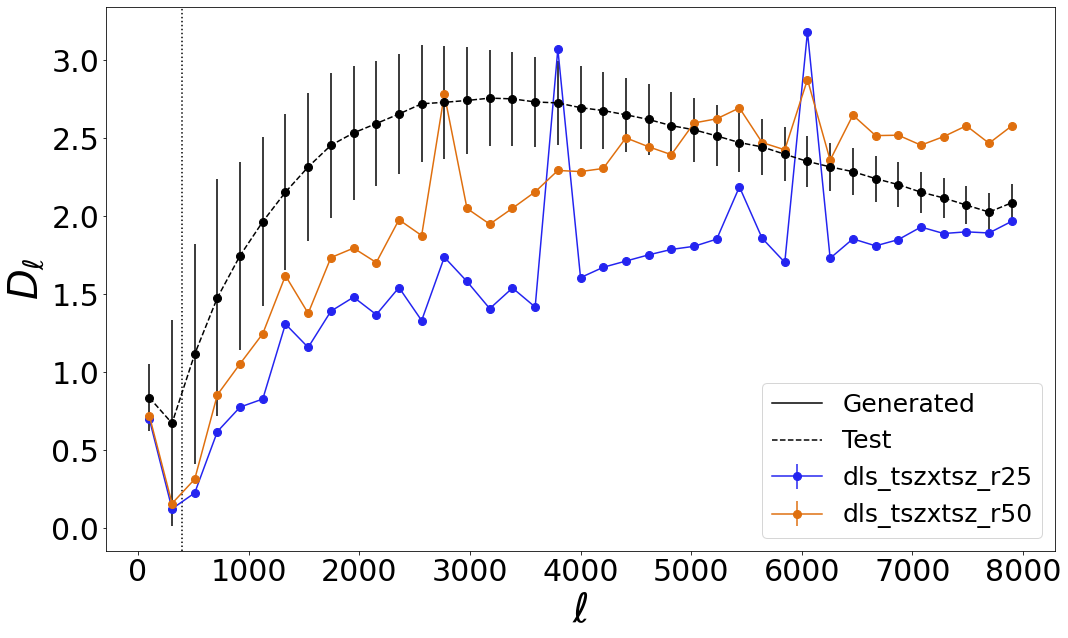

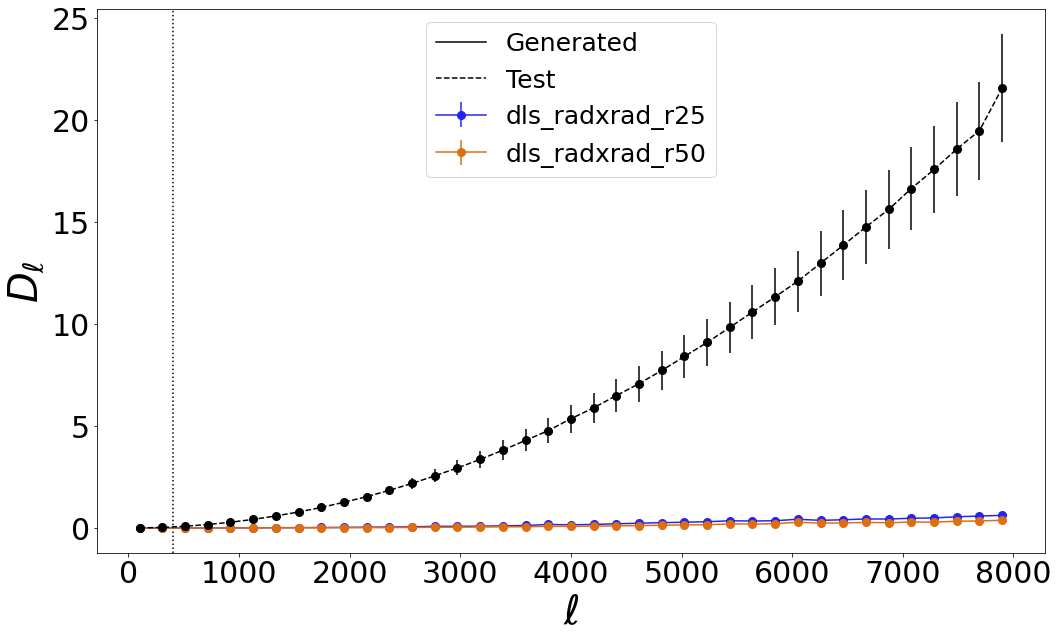

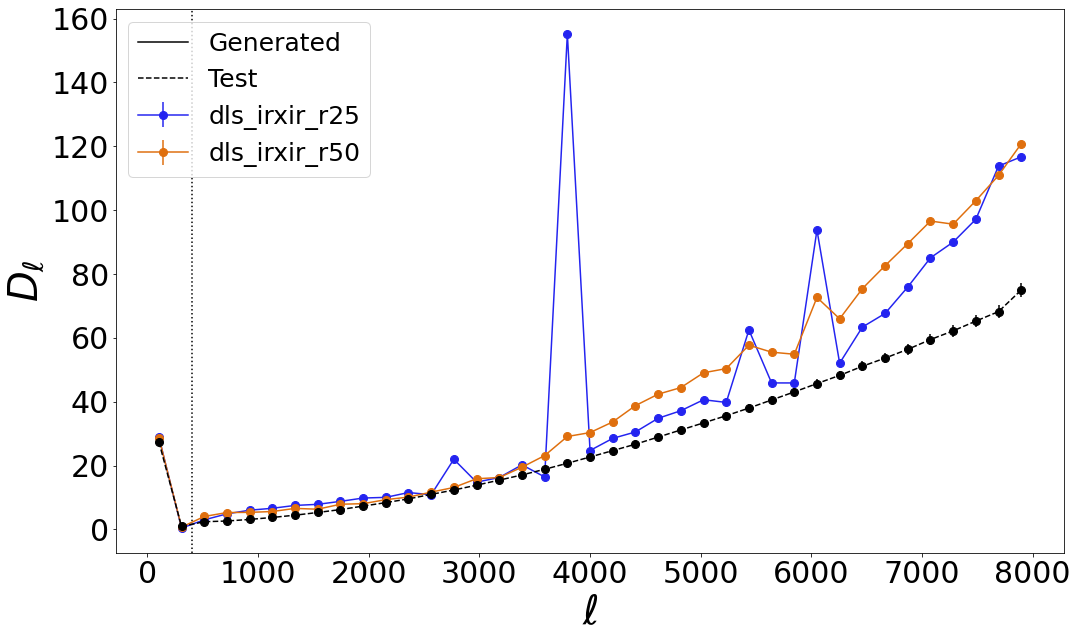

In [6]:
plt.clf()
compts = ["kappa", "ksz", "tsz", "rad", "ir"]
for key1 in compts:
    fig = plt.figure(figsize=(17,10))
    ax = fig.gca()
    key2 = key1
    key = [key1, key2]
    key.sort()
    key = "dls_"+"x".join(key)
   
    
    for save_point in save_points:#,20]:
        skey = key + "_r" + str(save_point)
        lbin = STAT_GEN.storage["lbin"][0].copy()
        dlbin = STAT_GEN.stats[skey]["mean"].copy()
        std = STAT_GEN.stats[skey]["std"].copy()
        plt.errorbar(lbin, dlbin, std,  marker="o",markersize=8, label=skey)
    
    lbin = STAT_TEST.storage["lbin"][0].copy()
    dlbin = STAT_TEST.stats[key]["mean"].copy()
    std = STAT_TEST.stats[key]["std"].copy()
    plt.errorbar(lbin, dlbin, std, marker="o",markersize=8, color="k", ls="--")
    #plt.plot(l, dls, alpha=0.3, label=key, ls="", marker="o", markersize=4)
    #plt.plot([],[], label=key, color=color)
    plt.plot([],[], ls="-",label="Generated", color="k")
    plt.plot([],[], ls="--",label="Test", color="k")
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    plt.ylabel(r"$D_\ell$", fontsize=40)
    plt.xlabel(r"$\ell$", fontsize=40)
    plt.legend(fontsize=25)
    #plt.ylim(1e-7,2e3)
    plt.axvline(x=400, ls=":", color="k")
    #plt.yscale("log")
    plt.show()

<Figure size 432x288 with 0 Axes>

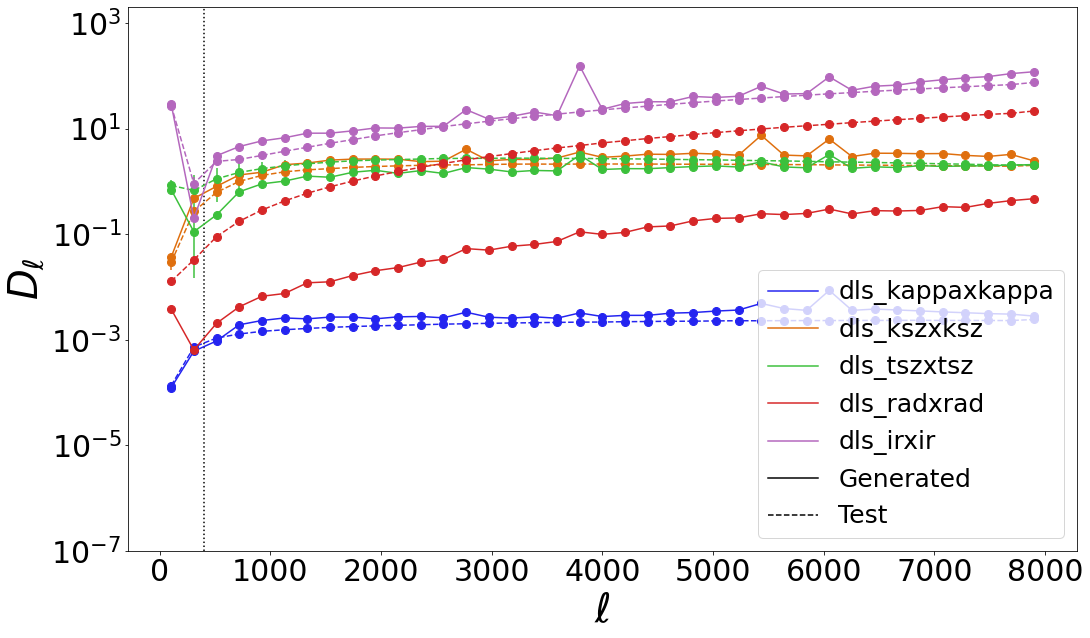

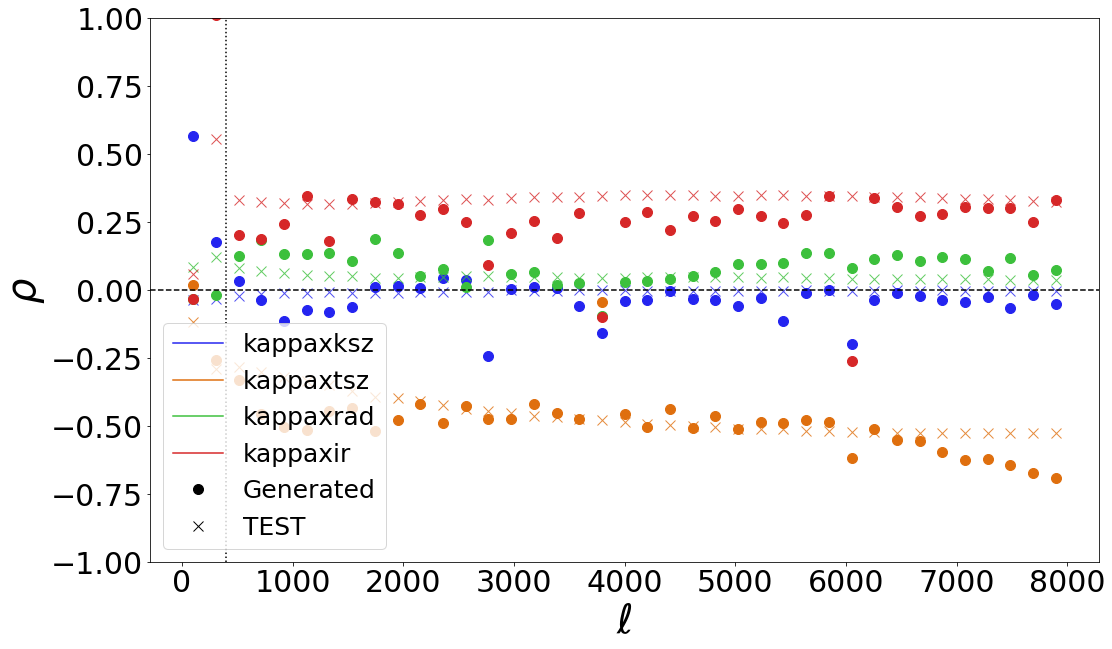

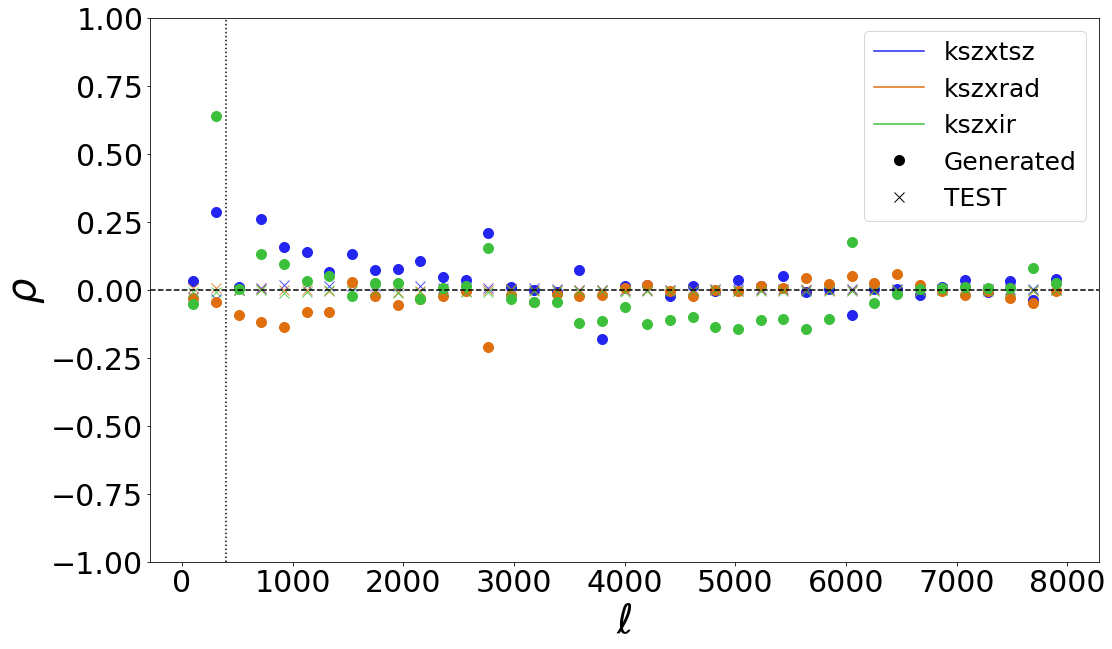

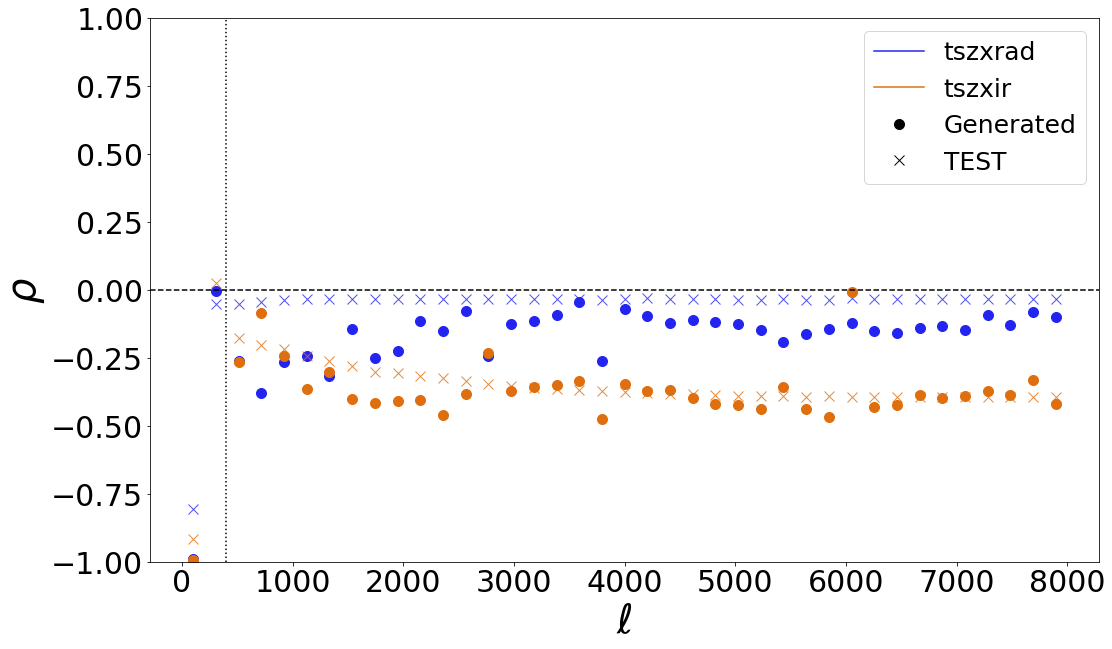

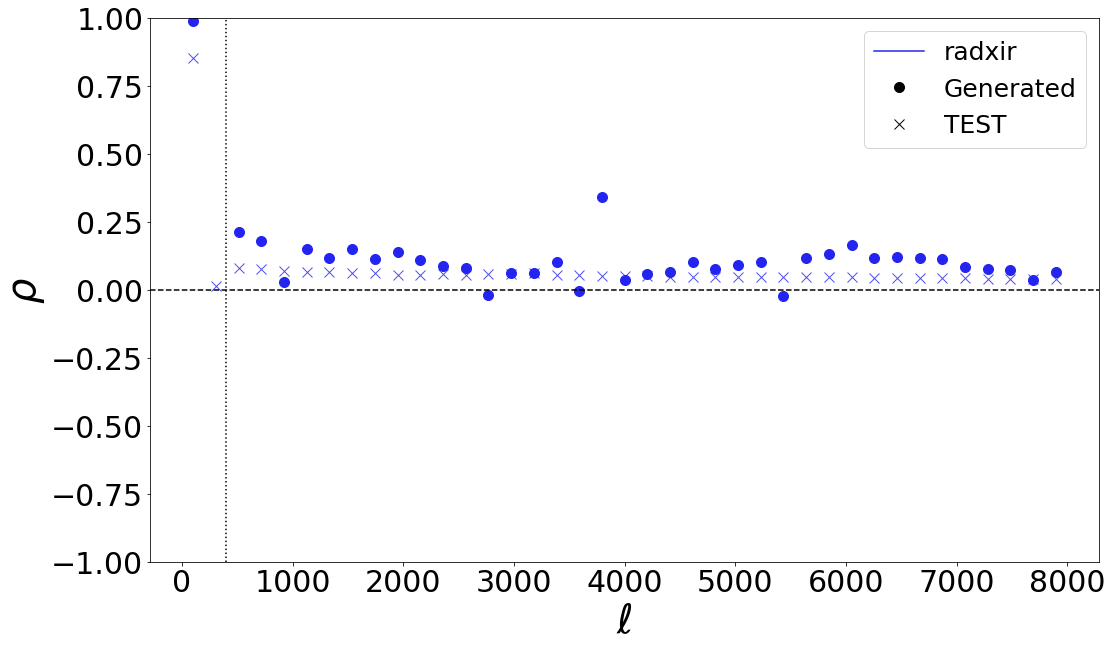

In [8]:
plt.clf()
fig = plt.figure(figsize=(17,10))
ax = fig.gca()
compts = ["kappa", "ksz", "tsz", "rad", "ir"]
for key1 in compts:
    key2 = key1
    key = [key1, key2]
    key.sort()
    key = "dls_"+"x".join(key)
    skey = key+"_r{}".format(save_points[-1])
    color = next(ax._get_lines.prop_cycler)['color']
    
    lbin = STAT_GEN.storage["lbin"][0]
    dlbin = STAT_GEN.stats[skey]["mean"]
    std = STAT_GEN.stats[skey]["std"]
    plt.errorbar(lbin, dlbin, std,  marker="o",markersize=8, color=color)
    
    lbin = STAT_TEST.storage["lbin"][0]
    dlbin = STAT_TEST.stats[key]["mean"]
    std = STAT_TEST.stats[key]["std"]
    plt.errorbar(lbin, dlbin, std, marker="o",markersize=8, color=color, ls="--")
    #plt.plot(l, dls, alpha=0.3, label=key, ls="", marker="o", markersize=4)
    plt.plot([],[], label=key, color=color)
plt.plot([],[], ls="-",label="Generated", color="k")
plt.plot([],[], ls="--",label="Test", color="k")
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
plt.ylabel(r"$D_\ell$", fontsize=40)
plt.xlabel(r"$\ell$", fontsize=40)
plt.legend(fontsize=25)
plt.ylim(1e-7,2e3)
plt.axvline(x=400, ls=":", color="k")
plt.yscale("log")
plt.show()

def get_correlation(STAT, key1, key2, postfix=""):
    key1 = compts[i]
    key2 = compts[j]
    key = [key1, key2]
    key.sort()
    key = "dls_"+"x".join(key)+postfix
    
    dls_x = STAT.stats[key]["mean"].copy()

    key = "dls_"+"x".join([key1, key1])+postfix
    dls_1 = STAT.stats[key]["mean"].copy()

    key = "dls_"+"x".join([key2, key2])+postfix
    dls_2 = STAT.stats[key]["mean"].copy()

    return dls_x/np.sqrt(dls_1*dls_2)
    

compts = ["kappa", "ksz", "tsz", "rad", "ir"]
for i in range(5-1):
    fig = plt.figure(figsize=(17,10))
    ax = fig.gca()
    for j in range(i+1,5):
        key1, key2 = compts[i], compts[j]
        lbin = STAT_GEN.storage["lbin"][0]
        color = next(ax._get_lines.prop_cycler)['color']
        rho = get_correlation(STAT_TEST, key1, key2)
        plt.plot(lbin, rho, alpha=0.8,  ls="", marker="x", markersize=10, color=color)

        rho = get_correlation(STAT_GEN, key1, key2, "_r{}".format(save_points[-1]))
        plt.plot(lbin, rho, alpha=1,  ls="", marker="o", markersize=10, color=color)
        plt.plot([],[], label="x".join([key1, key2]), color=color)
    plt.plot([],[], ls="",label="Generated", color="k",  marker="o", markersize=10)
    plt.plot([],[], ls="",label="TEST", color="k",  marker="x", markersize=10)

    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    plt.ylabel(r"$\rho$", fontsize=40)
    plt.xlabel(r"$\ell$", fontsize=40)
    plt.ylim(-1,1)
    plt.axvline(x=400, ls=":", color="k")
    plt.axhline(y=0, ls="--", color="k")
    plt.legend(fontsize=25)
    plt.show()
        
